In [1]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in  enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target,i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

In [4]:
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
mnist.data.shape

(70000, 784)

In [6]:
type(mnist)

sklearn.utils.Bunch

In [7]:
X, y = mnist['data'], mnist['target']

In [8]:
X.shape, y.shape

((70000, 784), (70000,))

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

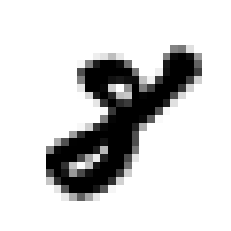

In [10]:
some_digit = X[52000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [12]:
y[52000]

8

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
import numpy as np

Shuffling data is dangerous in case of time-series data and that should be obvious :) though shuffeling is done so that cross-validation folds will be similar

In [15]:
shuffeling_index = np.random.permutation(60000)

In [16]:
X_train, y_train = X[shuffeling_index], y[shuffeling_index]

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
sgd_clf.predict([some_digit])

array([False])

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96525, 0.96605, 0.96425])

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [22]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clon_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clon_clf.fit(X_train_folds, y_train_folds)
    clon_prediction = clon_clf.predict(X_test_fold)
    n_correct = sum(clon_prediction == y_test_fold)
    print(n_correct/ len(clon_prediction))

C:\Users\shinigami\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96525
0.96605
0.96425


In [23]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clon_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clon_clf.fit(X_train_folds, y_train_folds)
    clon_prediction = clon_clf.predict(X_test_fold)
    n_correct = sum(clon_prediction == y_test_fold)
    print(n_correct/ len(clon_prediction))

0.96975
0.9554
0.96665


In [24]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
        

In [25]:
never_5 = Never5Classifier()

cross_val_score(never_5, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91   , 0.90885, 0.9101 ])

That's why accuracy is not preferred matrix as performance measure because it fails in skewed data (data which has certain quantities more than other)

#### Confusion Matrix
another method to calculate performance measure. The general idea is to calculate number of times instances of class `A`
is classified as class `B`

e.g 5 classified as 3

In [26]:
from sklearn.model_selection import cross_val_predict

cross_val_predict is same as cross_val_score now it just returns predictions rather estimator's scores

In [27]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_train_5, y_train_pred)

array([[53878,   701],
       [ 1388,  4033]], dtype=int64)

each row in confusion matrix represent an actual class while each column represents a predicted class. It is just like precision and recall but with matrix

In [30]:
y_train_5_perfect_predict = y_train_5

In [31]:
confusion_matrix(y_train_5, y_train_5_perfect_predict)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Precison = TP / (TP + FP) 

TP: True Positive FP: False Positive

Recall or Sensitivity or True Positive Rate(TPR)= TP / (TP + FN)

FN: False Negative



In [32]:
from sklearn.metrics import precision_score, recall_score

In [33]:
precision_score(y_train_5, y_train_pred)

0.851922264469793

In [34]:
recall_score(y_train_5, y_train_pred)

0.7439586792104778

basically precision je aahe na tyacha meaning aahe:je total number of true 5 aahet tyanchya peki kiti barobar olakhlet toh percentage number mhnje precision

recall: je 5 olakhlet (identified) tya peki khare 5 cha percentage kiti aahet



### F1-Score

f1-score is harmonic mean of precision and recall
while regular mean treates all values equally while harmonic mean gives much more weight to low values. as result classifier only get a high F1 score if both recall and precision both are high

F1-Score = TP /(TP + (FN + FP)/2)

In [35]:
from sklearn.metrics import f1_score

In [36]:
f1_score(y_train_5, y_train_pred)

0.7942885278188084

F1-score favors classifire that have similar precision and recall.

##### e.g.
1) suppose you trained a classifier to detect videos safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe videos (high precision), rather than a classifier that has a mch higher recall but lets a few really bad videos show up in your prodct(in such cases you want to add human pipeline).

1) on the other hand, suppose you train classifier to detect shoplifters on surveillance images:it is probably fine if your classifier has only 30% precision as long as it has 90% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught)


#### Increasing precision reduce recall and vice versa. this is precision-recall tradeoff



In [37]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

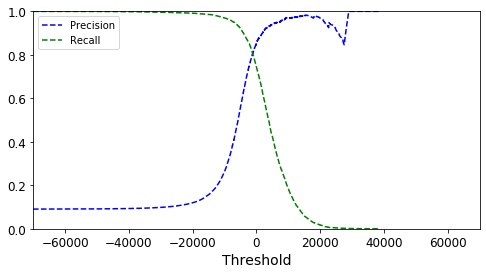

In [40]:
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
plt.show()

Precision may sometimes go down when you raise the threshold that's why it's curve is bumpier. on the other hand recall can only go down when the threshold is increased.

### ROC Curve

Receiver Operating Characteristic (ROC)

In [41]:
from sklearn.metrics import roc_curve

In [42]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    

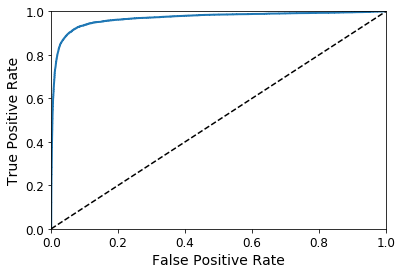

In [44]:
plot_roc_curve(fpr, tpr)
plt.show()

tradeoff:

high True Positive Rate then model will produce high False Positive items.

lint '---' represents true random classifier, a good classifier stays as far as from this line i.e. top-left corner


another way to measure performance is Area Under Curve (AUC) in ROC graph

a perfect classifier will have AUC 1 whereas purely random classifier has AUC 0.5

In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
roc_auc_score(y_train_5, y_scores)

0.9685731459988852

since ROC is similar to Precision/Recall (PR) curve, so how to decide which to use and when

prefer PR curve whenever the positive class is rare or when you care about the false positive than the false negatives and 
the ROC curve otherwise

e.g. ROC AUC score above might look intriguing but not good as instances of 5's are less

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
forest_clf = RandomForestClassifier(random_state = 42)

In [50]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [51]:
y_scores_forest = y_probas_forest[:, 1]

In [52]:
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5, y_scores_forest)

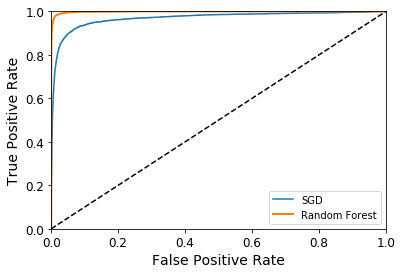

In [56]:
plt.plot(fpr, tpr, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plt.legend(loc="lower right")

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.998528303175082

In [63]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [64]:
precision_score(y_train_5, y_train_pred_forest)

0.9899328859060402

In [65]:
recall_score(y_train_5, y_train_pred_forest)

0.8706880649326693

#### Multinomial Classification

In [66]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([8], dtype=int8)

In [67]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [68]:
np.argmax(some_digit_scores)

8

In [69]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [70]:
from sklearn.multiclass import OneVsOneClassifier

In [71]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([8], dtype=int8)

In [72]:
len(ovo_clf.estimators_)

45

In [73]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([8], dtype=int8)

In [74]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.01, 0.  , 0.02, 0.  , 0.  , 0.96, 0.  ]])

In [76]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.875 , 0.8761, 0.8682])

In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [79]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [87]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9035 , 0.8991 , 0.89635])

In [81]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [82]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [83]:
conf_mx

array([[5577,    0,   14,    5,    8,   45,   34,    4,  235,    1],
       [   0, 6416,   38,   24,    3,   47,    4,    8,  194,    8],
       [  26,   28, 5259,   86,   68,   24,   55,   42,  360,   10],
       [  26,   21,  114, 5234,    1,  199,   23,   43,  404,   66],
       [  12,   14,   42,   11, 5220,   11,   34,   19,  323,  156],
       [  24,   17,   30,  151,   51, 4474,   77,   16,  515,   66],
       [  27,   15,   44,    1,   48,   90, 5543,    8,  142,    0],
       [  18,   10,   53,   21,   42,   11,    4, 5725,  184,  197],
       [  13,   65,   44,   86,    1,  134,   33,    8, 5420,   47],
       [  20,   19,   32,   57,  122,   34,    1,  184,  369, 5111]],
      dtype=int64)

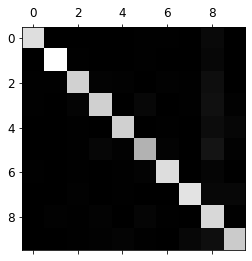

In [84]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [85]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

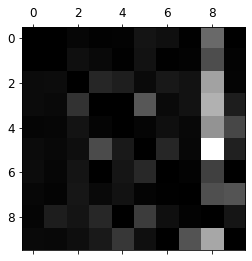

In [88]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Multilabel Classification

e.g recognizing multiple person from given images, face recoginition

In [90]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [91]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [92]:
knn_clf.predict([some_digit])

array([[ True, False]])

In [1]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

NameError: name 'cross_val_predict' is not defined

this assumes that all labels are equally important but that's not always the case. to give weight to labels use average="weighted"it will give weight to label to it's support(the number of instances with that target label)

### Excercise

### Q1


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]},
]

In [ ]:
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

### Q2

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshapre((28,28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]

shifted_image_down = shift_image(image, 0, 5)
shifited_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.imshow(shifited_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [lagel for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [ ]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_serach.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)